In [1]:
from simplex import simplex
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import numpy as np

Consider the following linear programming problem

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{z}}{\text{min}}
		& f(\mathbf{z}) & = -x_1+x_2 \\
		& \text{subject to}
		& 2x_1+3x_2 & \leq10\\
        & & -5x_1-2x_2 & \leq-2\\
        & & -2x_1+7x_2 & \leq8\\
        & & x_1 & \leq5\\
        & & x_2 & \geq-5\\
	\end{aligned}
\end{equation*}

We can solve this problem directly using ``scipy.optimize.linprog`` by defining the objective, constraint coefficients and upper and lower bounds for each variable.

``scipy.optimize.linprog`` does not support $\geq$ inequality constraints so we simply convert the last constraint to $\leq$ constraint by multiplying both sides by -1

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{z}}{\text{min}}
		& f(\mathbf{z}) & = -x_1+x_2 \\
		& \text{subject to}
		& 2x_1+3x_2 & \leq10\\
        & & -5x_1-2x_2 & \leq-2\\
        & & -2x_1+7x_2 & \leq8\\
        & & x_1 & \leq5\\
        & & -x_2 & \leq5\\
	\end{aligned}
\end{equation*}

In [2]:
obj = [-1, 1]
#      ─┬  ─┬
#       │   └┤ Coefficient for x1
#       └────┤ Coefficient for x2
lhs_ineq = [[ 2,  3],  # constraint g1 LHS
            [-5, -2],  # constraint g2 LHS
            [-2,  7],  # constraint g3 LHS
            [ 1,  0],  # constraint g4 LHS
            [ 0, -1]]  # constraint g5 LHS
rhs_ineq = [10,  # constraint g1 RHS
            -2,  # constraint g2 RHS
             8,  # constraint g3 RHS
             5,  # constraint g4 RHS
             5]  # constraint g5 RHS

bnd = [(None, None),  # Bounds of x1 (None implies it is unbounded)
#       ─┬      ─┬
#        │       └┤ upper bound for x1 (None implies it is unbounded)
#        └────┤ lower bound for x1 (None implies it is unbounded)
        (None, None)]  # Bounds of x2

We run the optimization to get the following results

In [3]:
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
                A_eq=None, b_eq=None, bounds=bnd,
                method="highs")

print("z_opt =", opt.x)
print("slack variables =", opt.slack)

z_opt = [ 5. -5.]
slack variables = [15. 13. 53.  0.  0.]


We will now solve the same problem using my user-defined algorithm ``simplex`` from [simplex.py](simplex.py).

First, we will have to convert the problem into standard form:

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{z}}{\text{min}}
		& f(\mathbf{z}) & = -x_1+x_2 \\
		& \text{subject to}
		& 2x_1+3x_2+s_1& = 10\\
        & & -5x_1-2x_2+s_2 & =-2\\
        & & -2x_1+7x_2+s_3 & =8\\
        & & x_1+s_4 & =5\\
        & & -x_2+s_5 & =5\\
        & & \mathbf{s} & \geq \mathbf{0}\\
	\end{aligned}
\end{equation*}

where $\mathbf{s} = \begin{bmatrix} s_1 & s_2 & s_3 & s_4 & s_5 \end{bmatrix}^\mathrm{T}$ are the slack variables. We also make the substitution $\mathbf{z} = \mathbf{u} - \mathbf{v}$ to avoid the restriction $\mathbf{z} \geq \mathbf{0}$ imposed by the standard form.

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{u},\mathbf{v}}{\text{min}}
		& f(\mathbf{u},\mathbf{v}) = -u_1+u_2+v_1-v_2 \\
		& \text{subject to}
		& 2u_1+3u_2-2v_1-3v_2+s_1& = 10\\
        & & -5u_1-2u_2+5v_1+2v_2+s_2 & =-2\\
        & & -2u_1+7u_2+2v_1-7v_2+s_3 & =8\\
        & & u_1-v_1+s_4 & =5\\
        & & -u_2+v_2+s_5 & =5\\
        & & \mathbf{s} & \geq \mathbf{0}\\
		& & \mathbf{u} & \geq \mathbf{0}\\
		& & \mathbf{v} & \geq \mathbf{0}\\
	\end{aligned}
\end{equation*}

We can easily write the coefficient matrices below for the standard form of the linear programming problem

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{x}}{\text{min}}
		& f(\mathbf{x}) = \mathbf{c}^\mathrm{T}\mathbf{x} \\
		& \text{subject to}
		& \mathbf{A}\mathbf{x}=\mathbf{b}
	\end{aligned}
\end{equation*}

where $\mathbf{x} = \begin{bmatrix} \mathbf{z} & \mathbf{u} & \mathbf{v} \end{bmatrix}^\mathrm{T}$ and 

$$
\mathbf{A} = \begin{bmatrix} 
	2 & 3 & -2 & -3 & 1 & 0 & 0 & 0 & 0\\
    -5 & -2 & 5 & 2 & 0 & 1 & 0 & 0 & 0\\
    -2 & 7 & 2 & -7 & 0 & 0 & 1 & 0 & 0\\
    1 & 0 & -1 & 0 & 0 & 0 & 0 & 1 & 0\\
    0 & -1 & 0 & 1 & 0 & 0 & 0 & 0 & 1
	\end{bmatrix}
\mathbf{b} = \begin{bmatrix} 10 \\ -2 \\ 8 \\ 5 \\ 5 \end{bmatrix}\\
~\\
\mathbf{c} = \begin{bmatrix} -1 & 1 & 1 & -1 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}^\mathrm{T}
$$

In [4]:
A = np.array([
    [2,3,-2,-3,1,0,0,0,0],
    [-5,-2,5,2,0,1,0,0,0],
    [-2,7,2,-7,0,0,1,0,0],
    [1,0,-1,0,0,0,0,1,0],
    [0,-1,0,1,0,0,0,0,1]], dtype="float64")
b = np.array([10,-2,8,5,5], dtype="float64")
c = np.array([-1,1,1,-1,0,0,0,0,0], dtype="float64")

c0 = c.copy()
k = 0
stop = False

k = 0
print("==================")
print("Simplex iterations")
z_opts = np.array([[0.0,0.0]])
while not stop:
    x_opt,stop = simplex(A,b,c)

    if not stop:
        k+=1
        print("iteration = %i" %k)
        print("A =", A)
        print("c =",c)
        print("b =",b)

    f_opt = c0[None,:] @ x_opt[:,None]
    z_opt = x_opt[0:2] - x_opt[2:4]
    z_opts = np.vstack((z_opts,z_opt))
    print("f_opt =",f_opt)
    print("x_opt =",x_opt)
    print("z_opt =",z_opt)

    print("==================")
    # input("hit ENTER to continue")

Simplex iterations
iteration = 1
A = [[ 0.   2.2  0.  -2.2  1.   0.4  0.   0.   0. ]
 [ 1.   0.4 -1.  -0.4 -0.  -0.2 -0.  -0.  -0. ]
 [ 0.   7.8  0.  -7.8  0.  -0.4  1.   0.   0. ]
 [ 0.  -0.4  0.   0.4  0.   0.2  0.   1.   0. ]
 [ 0.  -1.   0.   1.   0.   0.   0.   0.   1. ]]
c = [ 0.   1.4  0.  -1.4  0.  -0.2  0.   0.   0. ]
b = [9.2 0.4 8.8 4.6 5. ]
f_opt = [[0.]]
x_opt = [ 0.  0.  0.  0. 10.  0.  8.  5.  5.]
z_opt = [0. 0.]
iteration = 2
A = [[ 0.   0.   0.   0.   1.   0.4  0.   0.   2.2]
 [ 1.   0.  -1.   0.   0.  -0.2  0.   0.   0.4]
 [ 0.   0.   0.   0.   0.  -0.4  1.   0.   7.8]
 [ 0.   0.   0.   0.   0.   0.2  0.   1.  -0.4]
 [ 0.  -1.   0.   1.   0.   0.   0.   0.   1. ]]
c = [ 0.   0.   0.   0.   0.  -0.2  0.   0.   1.4]
b = [20.2  2.4 47.8  2.6  5. ]
f_opt = [[-0.4]]
x_opt = [0.4 0.  0.  0.  9.2 0.  8.8 4.6 5. ]
z_opt = [0.4 0. ]
iteration = 3
A = [[ 0.  0.  0.  0.  1.  0.  0. -2.  3.]
 [ 1.  0. -1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  2.  7.]
 [ 0.  0.  

/home/khalil/Papers/MECH_559_material/MECH559_notebooks/6_linear_programming/simplex.py:16: RuntimeWarning: divide by zero encountered in divide
  A_row = b / A[:,q]


The vector $\mathbf{z}^*$ tells us some useful information. We examine its components below
$$
\mathbf{x}^* = [\underset{\mathbf{u}}{\underbrace{\begin{matrix} 5 & 0 & \end{matrix}}}
\underset{\mathbf{v}}{\underbrace{\begin{matrix} 0 & 5 & \end{matrix}}}
\underset{\mathbf{s}}{\underbrace{\begin{matrix} 15 & 13 & 53 & 0 & 0 \end{matrix}}}]^\mathrm{T}
$$

We can see that what our optimizer $\mathbf{z}^* = \mathbf{u} - \mathbf{v} = \begin{bmatrix}5 & -5 \end{bmatrix}$.

The vector of slack variables $\mathbf{s} = \begin{bmatrix} 15 & 13 & 53 & 0 & 0 \end{bmatrix}$ tells us that only the 4th and 5th constraints are active. The first three constraints are inactive since their corresponding slack variables are greater than zero.

We plot the objective, constraints, and feasible region (shown in grey) below To demonstrate constraint activity. We also show the optimization path of the simplex algorithm.

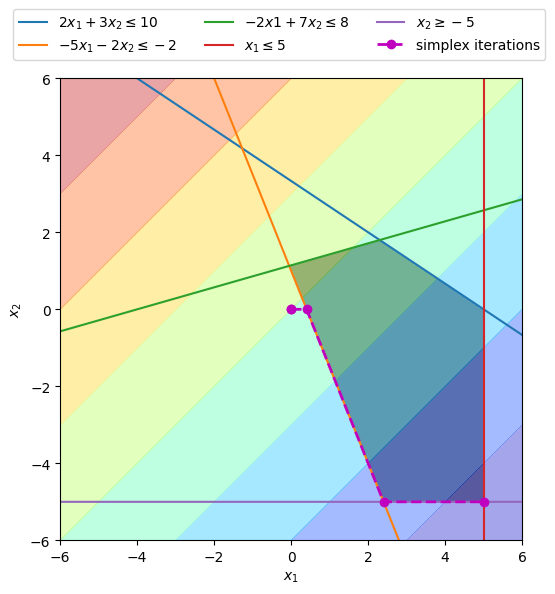

In [5]:
# plot the feasible region
d = np.linspace(-6,6,300)
X1,X2 = np.meshgrid(d,d)
F = -1*X1+1*X2
G1=2*X1+3*X2<=10
G2=-5*X1-2*X2<=-2
G3=-2*X1+7*X2<=8
G4=X1<=5
G5=X2>=-5


# plot the lines defining the constraints
x = np.linspace(-6, 6, 2000)
# 2*x1+3*x2<=10 
g1=(10-2*x)/3
# -5*x1-2*x2<=-2
g2=(2-5*x)/2
# -2*x1+7*x2<=8
g3=(8+2*x)/7
# x1<=5
g4=np.linspace(-6,6,100) # vertical line
# x2>=-5
g5=-5*np.ones_like((x)) # horizontal line

# Make plot
fig, ax = plt.subplots(figsize=(7,6))
plt.imshow( (G1 & G2 & G3 & G4 & G5).astype(int) , 
                extent=(X1.min(),X1.max(),X2.min(),X2.max()),origin="lower", cmap="Greys", alpha = 0.3)
ax.contourf(X1,X2,F,cmap="jet",alpha=0.5,zorder=-1)
ax.plot(x, g1, label=r"$2x_1+3x_2\leq10$")
ax.plot(x, g2, label=r"$-5x_1-2x_2\leq-2$")
ax.plot(x, g3, label=r"$-2x1+7x_2\leq8$")
ax.plot(5*np.ones_like(g4), g4, label=r"$x_1\leq5$")
ax.plot(x, g5, label=r"$x_2\geq-5$")
ax.plot(z_opts[:,0], z_opts[:,1],marker="o",linestyle="--",color="m",linewidth=2.0,label=r"simplex iterations")
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.legend(bbox_to_anchor=(1.05, 1.15), loc=1, borderaxespad=0., ncol=3)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$");
# fig.savefig("simplex_ex2.pdf",bbox_inches="tight")